In [1]:
using Pkg 
Pkg.activate("..");

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using RxInfer
using Random, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets, LaTeXStrings , StatsFuns
using Optim, ForwardDiff, Distributions, Flux
using KernelFunctions, MAT, LoopVectorization
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix 
using JLD

In [3]:
include("../helper_functions/gp_helperfunction.jl")
include("../GPnode/UniSGPnode.jl")
include("../helper_functions/derivative_helper.jl")
pgfplotsx()

Plots.PGFPlotsXBackend()

In [4]:
Random.seed!(3)
xmin, xmax = -4, 4  # Bounds of the data
N = 50# Number of samples
xtrain = sort(rand(Uniform(xmin, xmax), N))
xtest = collect(range(xmin - 0.1, xmax + 0.1; length=600));
precision = 100
ytrain = sinc.(xtrain) + randn(N) * sqrt(1/precision);
f_true = sinc.(xtest);


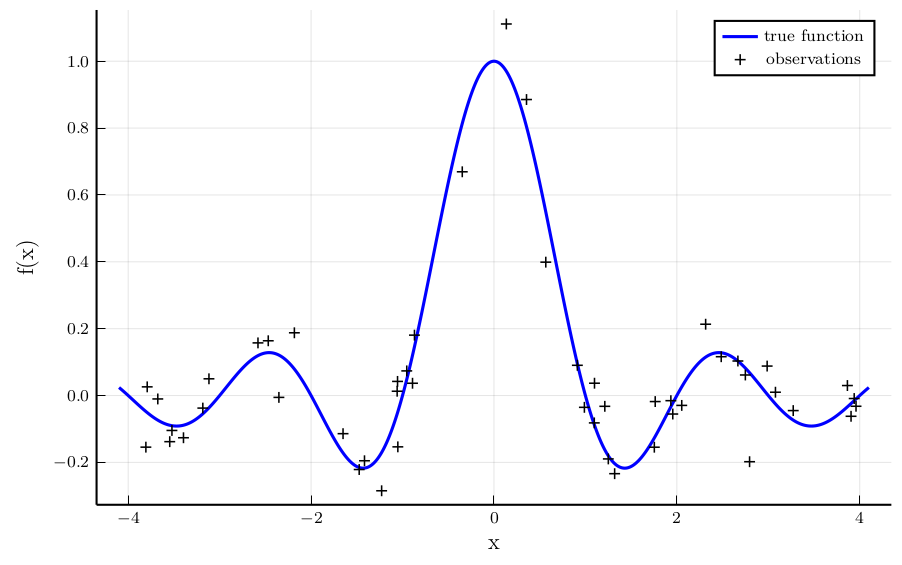

In [5]:
#Data visualization
plot(xtest,f_true,linewidth=1.5,label="true function", color =:blue)
scatter!(xtrain,ytrain, alpha=1, label="observations", ms=3.5, marker=:cross, legend=:topright)
xlabel!("x")
ylabel!("f(x)")

## Regression model

In [6]:
@model function gp_regression(y,x,Xu,θ)

    v ~ MvNormalMeanCovariance(zeros(length(Xu)), 50diageye(length(Xu)))
    w ~ GammaShapeRate(1e-2,1e-2)
    for i in eachindex(y)
        y[i] ~ UniSGP(x[i],v,w,θ) 
    end
end

gp_constraints = @constraints begin
    q(v,w) = q(v)q(w)
end

@meta function meta_gp_regression(Xu,Ψ0,Ψ1_trans,Ψ2,KuuL,kernel,Uv)
    UniSGP() -> UniSGPMeta(nothing,Xu,Ψ0,Ψ1_trans,Ψ2,KuuL,kernel,Uv,0, N)
end

gp_initialization = @initialization begin
    q(w) = GammaShapeRate(1e-2,1e-2)
end

Initial state: 
  q(w) = GammaShapeRate{Float64}(a=0.01, b=0.01)


In [7]:
Nu = 20; #number of inducing points 

Xu = range(-4,4;length=Nu);
mean_gp = (x) -> 0

kernel_gp(θ) = StatsFuns.softplus(θ[1]) * with_lengthscale(SEKernel(),StatsFuns.softplus(θ[2]))

θ_init = StatsFuns.invsoftplus.([1., 1.]);
gpcache = GPCache();

Ψ0 = [1.0;;]
Ψ1_trans = kernelmatrix(kernel_gp(θ_init),Xu,[xtrain[1]])
Ψ2 = kernelmatrix(kernel_gp(θ_init),Xu,[xtrain[1]]) * kernelmatrix(kernel_gp(θ_init),[xtrain[1]],Xu);
Kuu = kernelmatrix(kernel_gp(θ_init), Xu) + 1e-8 * I
Uv = cholesky(Kuu).U;

## Do inference

In [8]:
function my_free_energy(θ)
    kernelmatrix!(Kuu,kernel_gp(θ), Xu)
    KuuL = fastcholesky!(Kuu).L
    infer_result = infer(
        model = gp_regression(Xu = Xu, θ = θ),
        iterations = 7,
        data = (y = ytrain, x = xtrain,),
        initialization = gp_initialization,
        constraints = gp_constraints,
        returnvars = (v = KeepLast(),w = KeepLast(),),
        meta = meta_gp_regression(Xu,Ψ0,Ψ1_trans,Ψ2,KuuL,kernel_gp,Uv),
        free_energy = true,
    )    
    return (infer_result.free_energy[end], infer_result.posteriors[:v], infer_result.posteriors[:w])
end

function PerformInference(θ; epochs)
    FE_value = []
    q_v = []
    q_w = []
    θ_optimal = θ
    @inbounds for epoch=1:epochs
            #step 1: Perform inference for v, w 
            fe, qv,qw = my_free_energy(θ_optimal)
            #step 2: optimize the hyperparameters 
            μ_v, Σ_v = mean_cov(qv)
            Rv = Σ_v + μ_v * μ_v'|> (x) -> cholesky!(x).U
            w = mean(qw)

            negllh = (θ) -> neg_log_backwardmess_fast(θ;y_data=ytrain, x_data=xtrain,v = μ_v,Uv=Rv, w=w,kernel=kernel_gp,Xu=Xu)
            grad! = (G, θ) -> grad_llh_new_default!(G, θ ;y_data=ytrain, x_data=xtrain,v = μ_v,Uv=Rv, w=w,kernel=kernel_gp,Xu=Xu)
            res = optimize(negllh, grad!, θ_optimal, LBFGS(), Optim.Options(time_limit=1000))
            append!(FE_value,fe)
            push!(q_v, qv)
            push!(q_w,qw)
            θ_optimal = res.minimizer
    end
    return q_v, q_w, FE_value, θ_optimal
end

PerformInference (generic function with 1 method)

In [9]:
qv,qw, FE_value, θ_optimal = PerformInference(θ_init;epochs=300);

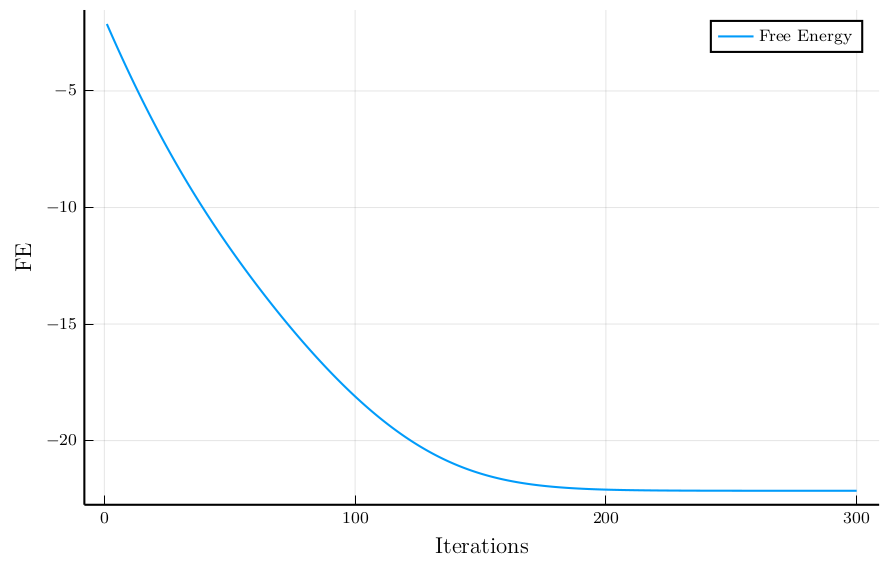

In [10]:
plot(FE_value,label = "Free Energy",
            xlabel = "Iterations",
            ylabel="FE",
            legend=:topright)

In [11]:
println("Optimal hyperparameters: ", StatsFuns.softplus.(θ_optimal))

Optimal hyperparameters: [0.03619750112503042, 0.5397814213749237]


In [12]:
# Variational posteriors of v and w 
qv = qv[end]
qw = qw[end]
;

In [13]:
##prediction
function predict_new(x_test,qv,qw,qθ, meta)
    prediction = @call_rule UniSGP(:out, Marginalisation) (q_in=PointMass(x_test),q_v = qv, q_w = qw,q_θ=qθ, meta=meta)
    return prediction
end

predict_new (generic function with 1 method)

In [14]:
predict_mean =[]
predict_var =[]
Kuu = kernelmatrix(kernel_gp(θ_optimal), Xu) + 1e-8 * I
KuuL = fastcholesky!(Kuu).L

for i=1:length(xtest)
    prediction = predict_new(xtest[i],qv,qw,PointMass(θ_optimal),UniSGPMeta(nothing,Xu,Ψ0,Ψ1_trans,Ψ2,KuuL,kernel_gp,Uv,0,N))
    append!(predict_mean,mean(prediction))
    append!(predict_var,var(prediction)) 
end

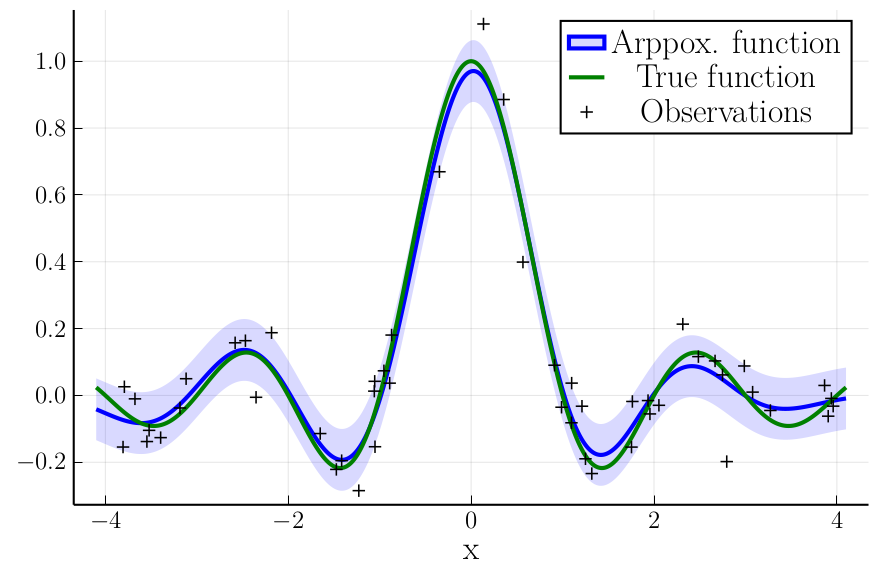

In [15]:
plot(xtest,predict_mean,ribbon = sqrt.(predict_var), tickfontsize=12,
    label="Arppox. function", lw=2,legend=:topright, color=:blue, fillalpha=0.15, fontfamily="monospace",legendfontsize=16, guidefontsize=16)
plot!(xtest,f_true,label="True function",lw=2, color=:green)
scatter!(xtrain,ytrain, label="Observations",  alpha=1, ms=4, marker=:cross)
xlabel!("x")

In [16]:
println("SMSE value of SGP node: ", SMSE(f_true, predict_mean))

SMSE value of SGP node: 0.008131895454357316


In [40]:
savefig("../texfiles/regression_result.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/regression_result.svg"

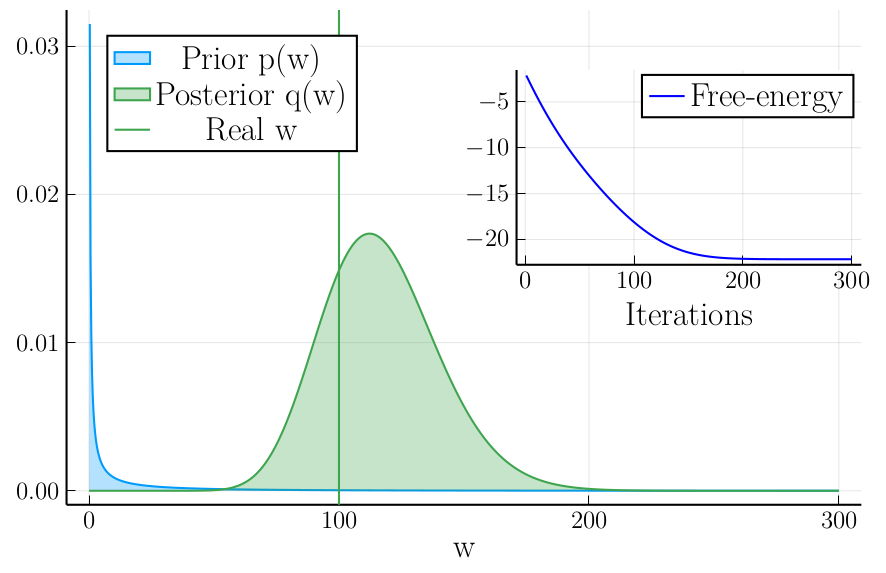

In [17]:
rw = range(0,300,length = 1000)


plot(rw, (x) -> pdf(GammaShapeRate(1e-2, 1e-2), x), fillalpha=0.3, fillrange = 0, label="Prior p(w)", c=1, fontfamily="monospace",legendfontsize=16,tickfontsize=12,guidefontsize=16 )
plot!(rw, (x) -> pdf(qw, x), fillalpha=0.3, fillrange = 0, label="Posterior q(w)", c=3, legend_position=(0.05,0.95))
vline!([precision], label="Real w")
xlabel!("w")

plot!(FE_value,label="Free-energy", legend=:topright, xlabel="Iterations",
        fontfamily="monospace",legendfontsize=16,
        color=:blue,
        tickfontsize=12,
        guidefontsize=16,
        inset = (1, bbox(0.0, 0.1, 0.5, 0.5, :top, :right)),
        subplot = 2)

In [42]:
savefig("../texfiles/regression_result_W.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/regression_result_W.svg"

In [20]:
## save data 
using JLD 
save("../savefiles/xtrain_toyregression.jld","xtrain",xtrain)
save("../savefiles/ytrain_toyregression.jld","ytrain",ytrain)
save("../savefiles/xtest_toyregression.jld","xtest",xtest)
save("../savefiles/ytest_toyregression.jld","ytest",f_true)
save("../savefiles/Xu_toyregression.jld","Xu",Xu)